# Main of the paper - LSR - $\sigma \neq 0.4$

In this notebook are gathered all experiments generated for the main of the paper using a least-squares regression which require presence of noise.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import RMSEModel

from src.machinery.GradientDescent import ArtemisDescent, DianaDescent, FL_VanillaSGD
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_linear, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "with_noise"

nb_devices_for_the_run = 10
dim_notebook = 20
MAX_NB_DEVICES = 40

In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=MAX_NB_DEVICES, with_seed=False, without_noise=False)
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

torch.Size([200, 21])


Text(0.5, 1.0, 'Model weights')

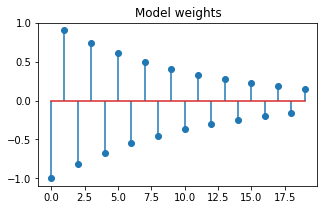

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [4]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([nb_devices_for_the_run]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=1000, 
                                                     momentum=0., 
                                                     quantization_param=0,
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False,
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

   it    |   obj   
     200 | 7.9016e-02
     400 | 7.9016e-02
     600 | 7.9016e-02
     800 | 7.9016e-02


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

Gradient Descent: execution time=1.987 seconds
Final loss :  0.07901604472426697

CPU times: user 2.62 s, sys: 7.78 ms, total: 2.63 s
Wall time: 2.03 s


In [5]:
obj_min_by_N_descent.model_params[-1]

tensor([ 2.0896, -1.0007,  0.9012, -0.8284,  0.7526, -0.6710,  0.6053, -0.5549,
         0.4898, -0.4204,  0.3951, -0.3709,  0.3282, -0.3060,  0.2636, -0.2385,
         0.2229, -0.2101,  0.1747, -0.1550,  0.1507], dtype=torch.float64)

In [6]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []

for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:47<03:11, 47.89s/it]

QSGD


 40%|████      | 2/5 [02:37<03:19, 66.52s/it]

Diana


 60%|██████    | 3/5 [04:16<02:32, 76.15s/it]

DblSqz


 80%|████████  | 4/5 [06:14<01:28, 88.62s/it]

Artemis


100%|██████████| 5/5 [07:50<00:00, 94.19s/it]

CPU times: user 7min 55s, sys: 444 ms, total: 7min 56s
Wall time: 7min 50s


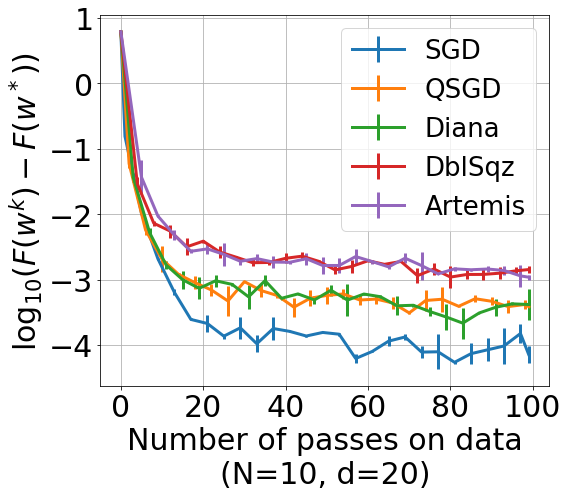

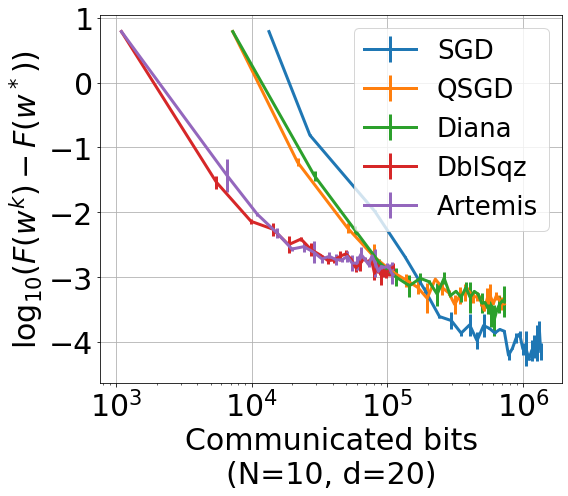

In [7]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
